# CV - ArcFace

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of the paper _ArcFace: Additive Angular Margin Loss for Deep Face Recognition_ in PyTorch.

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "../../../data/computer_vision/mnist/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => ../../../data/computer_vision/mnist/


In [5]:
os.listdir(root_dir)

['train', 'test']

## Load MNIST Data

### Preprocess Images

The MNIST-M images are 32x32 while the MNIST images are 28x28. We will resize all images to 28x28 and convert them to tensor. We will also Normalize our images. 

In [6]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
}

### Create Train and Test Datasets

In [7]:
# mnist
mnist_dataset_train = datasets.ImageFolder(root = root_dir + "train",
                                           transform = image_transforms["train"]
                                          )

mnist_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                           transform = image_transforms["test"]
                                          )

### Create Dataloader

In [8]:
BATCH_SIZE = 32

mnist_loader_train = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_loader_test = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=1, shuffle=False)

### Explore Data

#### Create ID <=> Class Mapping

In [9]:
mnist_dataset_train.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [10]:
idx2class = {v: k for k, v in mnist_dataset_train.class_to_idx.items()}
idx2class

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

## Train on MNIST

### Model Definition

In [11]:
class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, margin, scale):
        super(ArcFaceLayer, self).__init__()
        
        self.out_features = out_features
        self.margin = margin
        self.scale = scale
        
        self.weights = nn.Parameter(torch.Tensor(in_features, out_features))
        nn.init.kaiming_uniform_(self.weights)
    
    
    def forward(self, x, y):
        x = F.normalize(x)
        w = F.normalize(self.weights, dim = 0)
        
        z = F.linear(x, w.t(), bias=None)
        z = z.clip(-1+1e-7, 1-1e-7)
        
        theta = torch.acos(z)
        
        y_ohe = F.one_hot(y, num_classes=self.out_features) * self.margin
        
        theta += y_ohe
        
        logit = torch.cos(theta) * self.scale
        
        return logit

In [12]:
nc = 10
bs = 4
inp = torch.randn(bs, 20)
out = torch.arange(0, 4)

print(inp.shape, out.shape)

arcface = ArcFaceLayer(in_features=20, out_features=nc, margin=0.5, scale=64)

torch.Size([4, 20]) torch.Size([4])


In [13]:
arcface(inp, out)

tensor([[-24.4040,  -1.0503, -22.1329,  -3.0394,  -1.9205,  23.1811, -16.2176,
          10.7308,   6.3540,  24.5875],
        [-13.4032, -39.1501,  -0.9759,  13.1447,  15.7241,  -7.7913,  -5.0841,
         -17.2521,   9.9530,  -4.8562],
        [ -9.5502,  -0.3265, -36.2909,  13.5779,  -7.1374,  -5.2047,  -1.2488,
          -2.5875,   5.6342,  17.9715],
        [ 18.5096, -21.7403,  10.0308, -15.8909, -14.2189,   0.1537,   2.1041,
         -16.5752,   9.8097,  -5.5590]], grad_fn=<MulBackward0>)

In [14]:
class ModelMnistSource(nn.Module):
    def __init__(self, model_type):
        super(ModelMnistSource, self).__init__()
        
        self.model_type = model_type
        
        self.conv_block_1 = self.conv_block(c_in=3, c_out=20, kernel_size=3, stride=1, padding=1)
        self.conv_block_2 = self.conv_block(c_in=20, c_out=30, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(7*7*30, 3)
        
        if self.model_type == "arcface":
            self.arcface = ArcFaceLayer(in_features=3, out_features=10, margin=0.5, scale=64)
        elif self.model_type == "normal":
            self.fc2 = nn.Linear(3, 10)
        else:
            raise ValueError("Incorrect model type.")
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x, y):
        x = self.maxpool(self.conv_block_1(x))
        x = self.maxpool(self.conv_block_2(x))
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        
        if self.model_type == "arcface":
            x = self.arcface(x, y)
        elif self.model_type == "normal":
            x = self.fc2(x)
        else:
            raise ValueError("Incorrect model type.")
        
        return x
    
    def get_embeddings(self, x):
        x = self.maxpool(self.conv_block_1(x))
        x = self.maxpool(self.conv_block_2(x))
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        
        return x
    
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU()
        )
        
        return seq_block 

### Initialize Model

In [15]:
model_arcface = ModelMnistSource(model_type="arcface")
model_normal = ModelMnistSource(model_type="normal")

print(f"We're using {device}.\n")
model_arcface.to(device)
model_normal.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_arcface = optim.Adam(model_arcface.parameters(), lr=0.001)
optimizer_normal = optim.Adam(model_normal.parameters(), lr=0.001)

We're using cuda.



In [16]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

### Train Loop

In [17]:
def train_loop(model, data_loader_train, epochs, optimizer, criterion):
    
    print(f"{model.__class__.__name__} - {model.model_type} training has started.\n")
    
    for e in tqdm(range(1, epochs + 1)):
        train_epoch_loss = 0
        train_epoch_acc = 0

        model.train()
        for X_train_batch, y_train_batch in data_loader_train:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch, y_train_batch).squeeze()

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()

        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(data_loader_train):.5f} | Train Acc: {train_epoch_acc/len(data_loader_train):.3f}')
    
    print("\n\n")
    return model

In [18]:
EPOCHS = 20
model_normal_trained = train_loop(model_normal, mnist_loader_train, EPOCHS, optimizer_normal, criterion)
model_arcface_trained = train_loop(model_arcface, mnist_loader_train, EPOCHS, optimizer_arcface, criterion)

ModelMnistSource - normal training has started.



Epoch 001: | Train Loss: 0.37742 | Train Acc: 96.747
Epoch 002: | Train Loss: 0.17006 | Train Acc: 100.000
Epoch 003: | Train Loss: 0.13707 | Train Acc: 100.000
Epoch 004: | Train Loss: 0.11698 | Train Acc: 100.000
Epoch 005: | Train Loss: 0.10496 | Train Acc: 100.000
Epoch 006: | Train Loss: 0.09353 | Train Acc: 100.000
Epoch 007: | Train Loss: 0.08547 | Train Acc: 100.000
Epoch 008: | Train Loss: 0.07889 | Train Acc: 100.000
Epoch 009: | Train Loss: 0.07355 | Train Acc: 100.000
Epoch 010: | Train Loss: 0.06800 | Train Acc: 100.000
Epoch 011: | Train Loss: 0.06391 | Train Acc: 100.000
Epoch 012: | Train Loss: 0.06061 | Train Acc: 100.000
Epoch 013: | Train Loss: 0.05732 | Train Acc: 100.000
Epoch 014: | Train Loss: 0.05409 | Train Acc: 100.000
Epoch 015: | Train Loss: 0.05068 | Train Acc: 100.000
Epoch 016: | Train Loss: 0.04919 | Train Acc: 100.000
Epoch 017: | Train Loss: 0.04693 | Train Acc: 100.000
Epoch 018: | Train Loss: 0.04324 | Train Acc: 100.000
Epoch 019: | Train Loss: 0.04

Epoch 001: | Train Loss: 15.38164 | Train Acc: 51.573
Epoch 002: | Train Loss: 4.52858 | Train Acc: 99.520
Epoch 003: | Train Loss: 3.58369 | Train Acc: 99.947
Epoch 004: | Train Loss: 3.10097 | Train Acc: 100.000
Epoch 005: | Train Loss: 2.81970 | Train Acc: 100.000
Epoch 006: | Train Loss: 2.58188 | Train Acc: 100.000
Epoch 007: | Train Loss: 2.43978 | Train Acc: 100.000
Epoch 008: | Train Loss: 2.24775 | Train Acc: 100.000
Epoch 009: | Train Loss: 2.13498 | Train Acc: 100.000
Epoch 010: | Train Loss: 2.01940 | Train Acc: 100.000
Epoch 011: | Train Loss: 1.95155 | Train Acc: 100.000
Epoch 012: | Train Loss: 1.86907 | Train Acc: 100.000
Epoch 013: | Train Loss: 1.78354 | Train Acc: 100.000
Epoch 014: | Train Loss: 1.69591 | Train Acc: 100.000
Epoch 015: | Train Loss: 1.64740 | Train Acc: 100.000
Epoch 016: | Train Loss: 1.57715 | Train Acc: 100.000
Epoch 017: | Train Loss: 1.51526 | Train Acc: 100.000
Epoch 018: | Train Loss: 1.45387 | Train Acc: 100.000
Epoch 019: | Train Loss: 1.426

## Test on MNIST

In [19]:
def test_loop(model, data_loader_test):
    y_pred_list = []
    y_true_list = []

    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in tqdm(data_loader_test):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_test_pred = model(x_batch, y_batch)

            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)

            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())


    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    
    return y_pred_list, y_true_list

In [20]:
normal_y_pred_list, normal_y_true_list = test_loop(model_normal_trained, mnist_loader_test)
arcface_y_pred_list, arcface_y_true_list = test_loop(model_arcface_trained, mnist_loader_test)

In [21]:
def get_acc_report(model_type, y_true_list, y_pred_list):
    print(f"{model_type} classification report.")
    print(classification_report(y_true_list, y_pred_list))

In [22]:
get_acc_report("normal", normal_y_pred_list, normal_y_true_list)
get_acc_report("arcface", arcface_y_pred_list, arcface_y_true_list)

normal classification report.
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       996
           1       0.98      0.98      0.98      1136
           2       0.97      0.95      0.96      1055
           3       0.97      0.96      0.97      1017
           4       0.96      0.99      0.98       951
           5       0.97      0.98      0.98       880
           6       0.97      0.97      0.97       957
           7       0.97      0.97      0.97      1032
           8       0.95      0.97      0.96       956
           9       0.97      0.96      0.97      1020

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

arcface classification report.
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       960
           1       0.93      0.86      0.90      1222
           2     

## Visualize Embeddings

In [23]:
class_names = [i.item() for i in arcface_y_true_list]

In [24]:
def generate_embeddings(model, data_loader_test):
    
    print(f"Generating and compressing embeddings - {model.model_type}")

    emb_list = []
    with torch.no_grad():
        model.eval()
        for x_batch, y_batch in tqdm(data_loader_test):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            emb = model.get_embeddings(x_batch)
            emb_list.append(emb.cpu().tolist()[0])
            
#     compressed_embeddings = TSNE(n_components=3).fit_transform(emb_list)
    
    return emb_list

In [25]:
arcface_embeddings = generate_embeddings(model_arcface_trained, mnist_loader_test)
normal_embeddings = generate_embeddings(model_normal_trained, mnist_loader_test)

Generating and compressing embeddings - arcface



Generating and compressing embeddings - normal


In [26]:
def visualize_embeddings(compressed_embeddings, class_names, model_type):
    
    print(f"Visualizing embeddings - {model_type}")
    
    df = pd.DataFrame(compressed_embeddings, columns=["x0", "x1", "x2"])
    df["colour"] = class_names

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(df["x0"], df["x1"], df["x2"], c=df['colour'])

    plt.show()

Visualizing embeddings - arcface


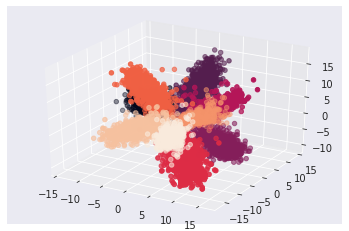

In [27]:
visualize_embeddings(arcface_embeddings, class_names, "arcface")

Visualizing embeddings - normal


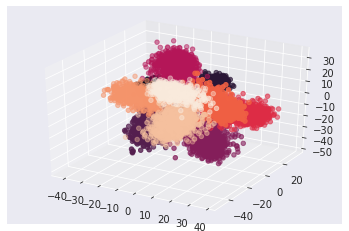

In [28]:
visualize_embeddings(normal_embeddings, class_names, "normal")